<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Results</a></span></li></ul></div>

# Packages

In [1]:
using Distributions, ForwardDiff

In [2]:
using Query, HTTP, CSV

In [3]:
using JuMP, Ipopt

In [4]:
using RCall


R version 3.6.2 (2019-12-12) -- "Dark and Stormy Night"
Copyright (C) 2019 The R Foundation for Statistical Computing
Platform: x86_64-w64-mingw32/x64 (64-bit)

R is free software and comes with ABSOLUTELY NO WARRANTY.
You are welcome to redistribute it under certain conditions.
Type 'license()' or 'licence()' for distribution details.

R is a collaborative project with many contributors.
Type 'contributors()' for more information and
'citation()' on how to cite R or R packages in publications.

Type 'demo()' for some demos, 'help()' for on-line help, or
'help.start()' for an HTML browser interface to help.
Type 'q()' to quit R.



In [5]:
using LinearAlgebra

# Data

Get the `Howel1` dataset and filter to only return adult heights:

In [6]:
file_url = "https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/Howell1.csv"
d = HTTP.get(file_url).body |> IOBuffer |> CSV.read

heights = @from i in d begin
    @where i.age >= 18
    @select i.height
    @collect
end

heights[1:5]

5-element Array{Float64,1}:
 151.765
 139.7  
 136.525
 156.845
 145.415

# Model

Define the priors:

In [7]:
prior_mean = Normal(178, 20)
prior_sd = Uniform(0, 50)
;

Define the objective function:

In [8]:
ll_data(μ, σ) = begin
    d = Normal(μ, σ)
    pdf.(d, heights) .|> log |> sum
end

l_param(θ, d) = pdf(d, θ) |> log

l_joint_priors(μ, σ) = l_param(μ, prior_mean) + l_param(σ, prior_sd)

objective_fn(μ, σ) = ll_data(μ, σ) + l_joint_priors(μ, σ)
;

Find the params that maximize the objective function:

In [9]:
model = Model(with_optimizer(Ipopt.Optimizer))

register(model, :objective_fn, 2, objective_fn, autodiff=true)

@variable(model, 98 <= a <= 258, start = rand(prior_mean))
@variable(model, 0 <= b <= 50, start = rand(prior_sd))

@NLobjective(model, Max, objective_fn(a, b))

In [10]:
optimize!(model)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        2
                     variables with only upper bounds:        0
Total number of equ

The value of μ and σ that maximize the objective function is:

In [11]:
optimal_points = [a, b] .|> value

2-element Array{Float64,1}:
 154.6070235817186 
   7.73133306282481

Get the covariance matrix that describes the relationship between μ and σ:

In [12]:
f(x::Vector) = begin
    a, b = x
    objective_fn(a, b)
end

H(x::Vector) = ForwardDiff.hessian(f, x)

covar_mat = inv(-1 * H(optimal_points))

2×2 Array{Float64,2}:
 0.16974      0.000218032
 0.000218032  0.0849058  

Get the standard deviation of the parameter μ and σ:

In [13]:
diag(covar_mat) .|> sqrt

2-element Array{Float64,1}:
 0.41199467416507857
 0.29138605897059755

# Results

Now we can sample from our updated priors i.e posterior distribution and generate some heights and compare it with actual heights:

In [14]:
# not rounding the covariance matrix will throw a PosDefException
covar_mat_r = map(covar_mat) do x
    round(x, digits=5)
end

posterior = MvNormal(optimal_points, covar_mat_r)

trials = Int(10e3)
posterior_samples = rand(posterior, trials)

posterior_heights = map(eachcol(posterior_samples)) do (sample_μ, sample_σ)
    d = Normal(sample_μ, sample_σ)
    height = rand(d) 
end
;

Also generate some sample heights based on our priors for comparison:

In [15]:
prior_samples = zip(rand(prior_mean, trials), rand(prior_sd, trials))
prior_heights = map(prior_samples) do (sample_μ, sample_σ)
    d = Normal(sample_μ, sample_σ)
    height = rand(d)
end
;

┌ Warning: RCall.jl: -- Attaching packages --------------------------------------- tidyverse 1.3.0 --
│ v ggplot2 3.2.1     v purrr   0.3.3
│ v tibble  2.1.3     v dplyr   0.8.3
│ v tidyr   1.0.0     v stringr 1.4.0
│ v readr   1.3.1     v forcats 0.4.0
│ -- Conflicts ------------------------------------------ tidyverse_conflicts() --
│ x dplyr::filter() masks stats::filter()
│ x dplyr::lag()    masks stats::lag()
└ @ RCall C:\Users\mshukri\.julia\packages\RCall\lAV2K\src\io.jl:113


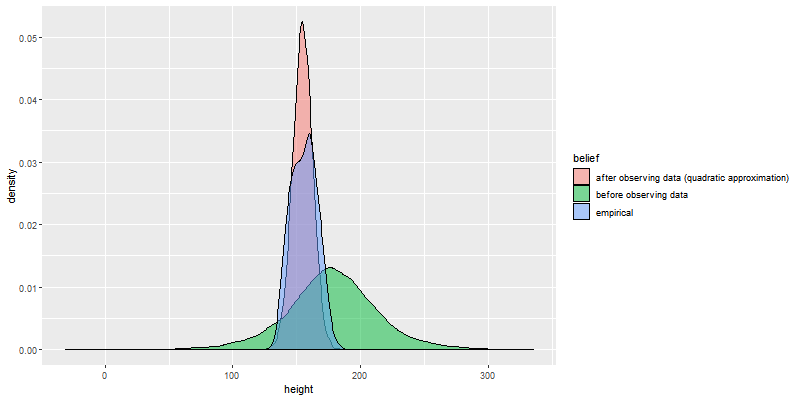

RObject{VecSxp}


In [16]:
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 800, :height => 400))

R"""
library(tidyverse)

empirical_heights = $(heights)
prior_heights = $(prior_heights)
posterior_heights =$(posterior_heights)


df <- tibble(height=empirical_heights, belief="empirical") %>%
  union(tibble(height=prior_heights, belief="before observing data")) %>%
  union(tibble(height=posterior_heights, belief="after observing data (quadratic approximation)"))

ggplot(df, aes(x=height, fill=belief)) +
  geom_density(alpha=0.5)
"""

Summarize the marginal posterior distributions (notice thatt they are very similar to the [grid approximation](modelling_height-grid_approximation.ipynb) method):

In [17]:
gposterior_means = posterior_samples[1,:]
posterior_sds = posterior_samples[2,:]
;

In [18]:
R"rethinking::HPDI($(posterior_means))"

UndefVarError: UndefVarError: posterior_means not defined

In [19]:
R"rethinking::HPDI($(posterior_sds))"

RObject{RealSxp}
   |0.89    0.89| 
7.281256 8.201761 
